In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sqlite3
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torchvision import models, transforms
from PIL import Image

# Load pre-trained ResNet model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Remove the last layer
model.eval()

# Define image preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def load_embeddings_in_batches(file_path, batch_size):
    with open(file_path, 'rb') as f:
        data = pd.read_pickle(f)
    uuids = list(data.keys())
    embeddings = list(data.values())
    for i in range(0, len(embeddings), batch_size):
        yield uuids[i:i + batch_size], embeddings[i:i + batch_size]

def compute_embedding(img_path, model):
    img = Image.open(img_path).convert('RGB')
    img_tensor = preprocess(img)
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        embedding = model(img_tensor)
    embedding = embedding.view(-1).numpy()  # Flatten the embedding
    return embedding

def find_top_similar_images(embedding, embeddings_batches, top_n=5):
    all_similarities = []
    all_uuids = []
    
    for uuids_batch, embeddings_batch in embeddings_batches:
        similarities = cosine_similarity([embedding], embeddings_batch)[0]
        all_similarities.extend(similarities)
        all_uuids.extend(uuids_batch)
    
    all_similarities = np.array(all_similarities)
    top_indices = all_similarities.argsort()[-top_n:][::-1]
    return [all_uuids[i] for i in top_indices]

def load_image_paths_from_db(db_path, uuids):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    placeholders = ', '.join(['?'] * len(uuids))
    query = f"SELECT uuid, file_path FROM images WHERE uuid IN ({placeholders})"
    cursor.execute(query, uuids)
    rows = cursor.fetchall()
    conn.close()
    return {row[0]: row[1] for row in rows}

def plot_images(main_image_path, top_similar_images_paths):
    plt.figure(figsize=(20, 10))
    
    main_image = cv2.imread(main_image_path)
    if main_image is None:
        raise ValueError(f"Main image not found at path: {main_image_path}")
    main_image = cv2.cvtColor(main_image, cv2.COLOR_BGR2RGB)
    plt.subplot(1, len(top_similar_images_paths) + 1, 1)
    plt.imshow(main_image)
    plt.title('Input Image')
    plt.axis('off')
    
    for i, img_path in enumerate(top_similar_images_paths):
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Similar image not found at path: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(top_similar_images_paths) + 1, i + 2)
        plt.imshow(img)
        plt.title(f'Similar Image {i+1}')
        plt.axis('off')
    
    plt.show()

# Example usage
input_image_path = "new_images/try1.jpg"  # Path to the input image
cosine_similarities_path = "combined_embeddings.pkl"  # Path to precomputed dataset embeddings
database_path = "image_metadata.db"  # Path to the database
batch_size = 1000  # Adjust batch size according to memory capacity

# Compute embedding for the new image
print(f"Computing embedding for the new image: {input_image_path}")
new_image_embedding = compute_embedding(input_image_path, model)
print("Embedding computed.")

# Load embeddings in batches and find top similar images
print("Finding top similar images...")
embeddings_batches = load_embeddings_in_batches(cosine_similarities_path, batch_size)
top_similar_images = find_top_similar_images(new_image_embedding, embeddings_batches)
print(f"Top similar images: {top_similar_images}")

# Load image paths from the database
print("Loading image paths from the database...")
image_paths_dict = load_image_paths_from_db(database_path, top_similar_images)
print(f"Image paths loaded: {image_paths_dict}")

# Get the paths for the similar images
top_similar_images_paths = [image_paths_dict[uuid] for uuid in top_similar_images]
print(f"Top similar images paths: {top_similar_images_paths}")

# Plot the images
print("Plotting images...")
plot_images(input_image_path, top_similar_images_paths)
print("Images plotted.")



Computing color histogram for the input image: new_images/try5.jpg
Color histogram computed.
Finding top similar images based on color histograms using Histogram Intersection...
Top similar images: ['9a636082-c419-40d4-b22f-d3465a7f5a1a', '1551c6a2-fd6c-42e2-864b-0ab46cbf8ba6', '947a3edd-3661-46d9-b538-a3fb10cf7268', '449b3bfe-7fd2-4e01-bf20-d1e15386cb66', '1f1bcfcf-e28d-48db-9619-9e57127e9e67']
Loading image paths from the database...
Image paths loaded: {'449b3bfe-7fd2-4e01-bf20-d1e15386cb66': 'E:/data/image_data\\coco2017_unlabeled\\unlabeled2017\\000000002906.jpg', '947a3edd-3661-46d9-b538-a3fb10cf7268': 'E:/data/image_data\\coco2017_unlabeled\\unlabeled2017\\000000192358.jpg', '9a636082-c419-40d4-b22f-d3465a7f5a1a': 'E:/data/image_data\\coco2017_unlabeled\\unlabeled2017\\000000224500.jpg', '1551c6a2-fd6c-42e2-864b-0ab46cbf8ba6': 'E:/data/image_data\\coco2017_unlabeled\\unlabeled2017\\000000290721.jpg', '1f1bcfcf-e28d-48db-9619-9e57127e9e67': 'E:/data/image_data\\coco2017_unlabele

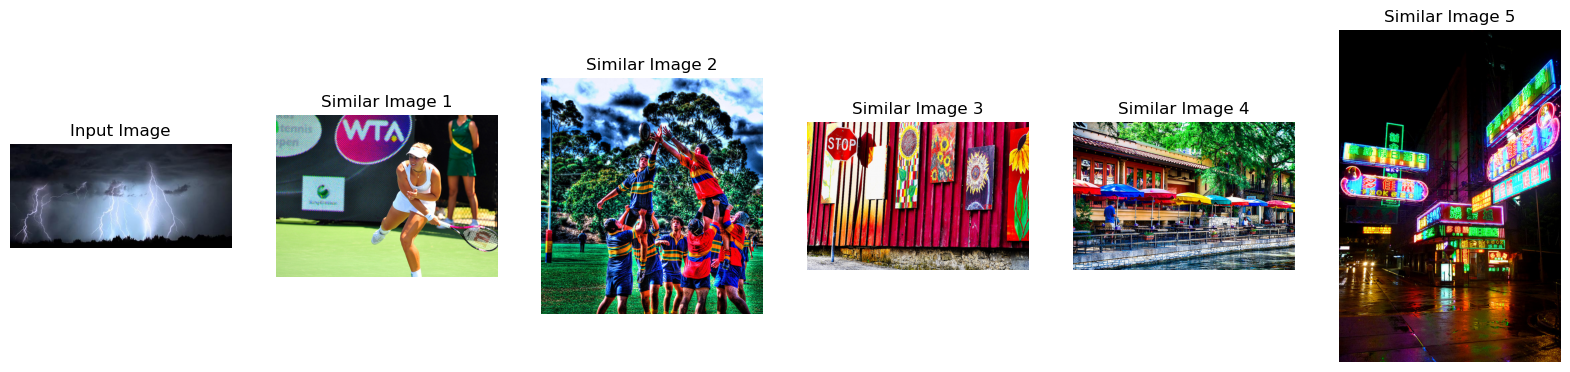

Images plotted.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from scipy.spatial.distance import cdist
import sqlite3

# Function to load pickled data
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        return pd.read_pickle(f)

# Function to compute the color histogram for an image
def compute_color_histogram(image_path, bins=(16, 16, 16)):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found at path: {image_path}")
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv_image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

# Function to compute Histogram Intersection
def histogram_intersection(hist1, hist2):
    return np.sum(np.minimum(hist1, hist2))

# Function to find top N similar images based on color histograms using Histogram Intersection
def find_top_color_similar_images(target_hist, color_histograms, top_n=5):
    # Calculate similarities for color histograms
    all_uuids = list(color_histograms.keys())
    all_histograms = list(color_histograms.values())
    similarities = [histogram_intersection(target_hist, hist) for hist in all_histograms]
    
    # Get indices of the top N similar images (higher score means more similar)
    top_similar_indices = np.argsort(similarities)[-top_n:]  # Get top N indices
    top_similar_uuids = [all_uuids[idx] for idx in top_similar_indices]
    
    return top_similar_uuids

# Function to load image paths from the database
def load_image_paths_from_db(db_path, uuids):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    placeholders = ', '.join(['?'] * len(uuids))
    query = f"SELECT uuid, file_path FROM images WHERE uuid IN ({placeholders})"
    cursor.execute(query, uuids)
    rows = cursor.fetchall()
    conn.close()
    return {row[0]: row[1] for row in rows}

# Function to plot images
def plot_images(main_image_path, top_similar_images_paths):
    plt.figure(figsize=(20, 10))

    # Plot the main image
    main_image = cv2.imread(main_image_path)
    if main_image is None:
        raise ValueError(f"Main image not found at path: {main_image_path}")
    main_image = cv2.cvtColor(main_image, cv2.COLOR_BGR2RGB)
    plt.subplot(1, len(top_similar_images_paths) + 1, 1)
    plt.imshow(main_image)
    plt.title('Input Image')
    plt.axis('off')

    # Plot the similar images
    for i, img_path in enumerate(top_similar_images_paths):
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Similar image not found at path: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(top_similar_images_paths) + 1, i + 2)
        plt.imshow(img)
        plt.title(f'Similar Image {i+1}')
        plt.axis('off')

    plt.show()

# Example usage
input_image_paths = [
    "new_images/try5.jpg",
]  # Paths to the input images

color_histograms_path = "combined_color_histograms.pkl"  # Path to precomputed color histograms
database_path = "image_metadata.db"

# Load color histograms from pickle file
color_histograms = load_pickle(color_histograms_path)

for input_image_path in input_image_paths:
    # Compute the color histogram for the input image
    print(f"\nComputing color histogram for the input image: {input_image_path}")
    input_image_histogram = compute_color_histogram(input_image_path)
    print("Color histogram computed.")

    # Find top similar images based on color histograms using Histogram Intersection
    print("Finding top similar images based on color histograms using Histogram Intersection...")
    top_similar_uuids = find_top_color_similar_images(input_image_histogram, color_histograms)
    print(f"Top similar images: {top_similar_uuids}")

    # Load image paths from the database
    print("Loading image paths from the database...")
    image_paths_dict = load_image_paths_from_db(database_path, top_similar_uuids)
    print(f"Image paths loaded: {image_paths_dict}")

    # Get the main image path and the top similar images paths
    main_image_path = input_image_path  # Use the input image as the main image
    top_similar_images_paths = [image_paths_dict[uuid] for uuid in top_similar_uuids]

    # Debugging print statements
    print(f"Main image path: {main_image_path}")
    print(f"Top similar images paths: {top_similar_images_paths}")

    # Plot the images
    print("Plotting images...")
    plot_images(main_image_path, top_similar_images_paths)
    print("Images plotted.")
